Notes and code inspired from lecture by Andrej Karpathy https://www.youtube.com/watch?v=kCc8FmEb1nY

- Build a gpt-decoder from scratch
- Trained with tiny-shakespear
- Output 'babble' that replicate shakespear text
- Notes on chatGPT infrastructure and finetuning stage that enable question-answer style 

Also builds in new data sources, tokenization strategies and checkpointing

In [85]:
!python -m pip install --upgrade pip
%pip install wget

In [86]:
!python -m wget https://raw.githubusercontent.com/karpathy/char-rnn/master/data/tinyshakespeare/input.txt


Saved under input (1).txt


In [2]:
%pip install torch torchvision torchaudio --extra-index-url https://download.pytorch.org/whl/cu117


Looking in indexes: https://pypi.org/simple, https://download.pytorch.org/whl/cu117
     ---------------------------------------- 0.0/4.8 MB ? eta -:--:--
     --- ------------------------------------ 0.4/4.8 MB 13.2 MB/s eta 0:00:01
     ------- -------------------------------- 0.9/4.8 MB 11.0 MB/s eta 0:00:01
     ----------- ---------------------------- 1.4/4.8 MB 11.1 MB/s eta 0:00:01
     --------------- ------------------------ 1.9/4.8 MB 11.0 MB/s eta 0:00:01
     -------------------- ------------------- 2.4/4.8 MB 11.0 MB/s eta 0:00:01
     ------------------------ --------------- 3.0/4.8 MB 11.2 MB/s eta 0:00:01
     ---------------------------- ----------- 3.4/4.8 MB 10.9 MB/s eta 0:00:01
     -------------------------------- ------- 4.0/4.8 MB 11.0 MB/s eta 0:00:01
     ------------------------------------ --- 4.4/4.8 MB 10.7 MB/s eta 0:00:01
     ---------------------------------------  4.8/4.8 MB 10.6 MB/s eta 0:00:01
     ---------------------------------------- 4.8/4.8 M

In [1]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
print(device)

cpu


In [2]:
with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
print("dataset length: ", len(text))
#print(text[:1000])

dataset length:  1115394


In [3]:
# Get the unique set of characters in corpus, sorted
chars = sorted(list(set(text)))
vocab_size = len(chars)
print(''.join(chars))
print(vocab_size)


 !$&',-.3:;?ABCDEFGHIJKLMNOPQRSTUVWXYZabcdefghijklmnopqrstuvwxyz
65


In [4]:
# tokenize corpus 
# convert input to some sequence of integers
# translate char - int
stoi = { ch:i for i, ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}

# encoder: convert each char to int index
# decoder: take int and translate to string 
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l]) 

print(encode("hi there"))
print(decode(encode("hi there")))




[46, 47, 1, 58, 46, 43, 56, 43]
hi there


In [5]:
#SentencePiece from Google is another encode/decode that uses sub-word units
#instead of individual characters 
%pip install tiktoken

import tiktoken
enc = tiktoken.get_encoding("gpt-2")
assert enc.decode(enc.encode("hello world")) == "hello world"

Note: you may need to restart the kernel to use updated packages.


ValueError: Unknown encoding gpt-2

In [ ]:
#pytorch
%pip install torch 

Note: you may need to restart the kernel to use updated packages.


In [9]:
import torch
data = torch.tensor(encode(text), dtype=torch.long)
print(data.shape, data.dtype)
print(data[:1000])


torch.Size([1115394]) torch.int64
tensor([18, 47, 56, 57, 58,  1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 14, 43, 44,
        53, 56, 43,  1, 61, 43,  1, 54, 56, 53, 41, 43, 43, 42,  1, 39, 52, 63,
         1, 44, 59, 56, 58, 46, 43, 56,  6,  1, 46, 43, 39, 56,  1, 51, 43,  1,
        57, 54, 43, 39, 49,  8,  0,  0, 13, 50, 50, 10,  0, 31, 54, 43, 39, 49,
         6,  1, 57, 54, 43, 39, 49,  8,  0,  0, 18, 47, 56, 57, 58,  1, 15, 47,
        58, 47, 64, 43, 52, 10,  0, 37, 53, 59,  1, 39, 56, 43,  1, 39, 50, 50,
         1, 56, 43, 57, 53, 50, 60, 43, 42,  1, 56, 39, 58, 46, 43, 56,  1, 58,
        53,  1, 42, 47, 43,  1, 58, 46, 39, 52,  1, 58, 53,  1, 44, 39, 51, 47,
        57, 46, 12,  0,  0, 13, 50, 50, 10,  0, 30, 43, 57, 53, 50, 60, 43, 42,
         8,  1, 56, 43, 57, 53, 50, 60, 43, 42,  8,  0,  0, 18, 47, 56, 57, 58,
         1, 15, 47, 58, 47, 64, 43, 52, 10,  0, 18, 47, 56, 57, 58,  6,  1, 63,
        53, 59,  1, 49, 52, 53, 61,  1, 15, 39, 47, 59, 57,  1, 25, 39, 56, 41,
      

In [10]:
# spearate train and validation data sets
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]



In [11]:
#split corpus into blocks for efficiency
block_size = 8
train_data[:block_size+1]

tensor([18, 47, 56, 57, 58,  1, 15, 47, 58])

In [12]:
x = train_data[:block_size]
y = train_data[1:block_size+1]
for t in range(block_size):
    context = x[:t+1]
    target = y[t]
    print(f"when input is {context} the target: {target}")

# these are the 8 examples spelled out from the training set
# the 8-size is for efficiency AND context
# as little as 1 character context allows a predicition
# more than block size input will be superflous

when input is tensor([18]) the target: 47
when input is tensor([18, 47]) the target: 56
when input is tensor([18, 47, 56]) the target: 57
when input is tensor([18, 47, 56, 57]) the target: 58
when input is tensor([18, 47, 56, 57, 58]) the target: 1
when input is tensor([18, 47, 56, 57, 58,  1]) the target: 15
when input is tensor([18, 47, 56, 57, 58,  1, 15]) the target: 47
when input is tensor([18, 47, 56, 57, 58,  1, 15, 47]) the target: 58


In [13]:
torch.manual_seed(1337)
batch_size = 4 # parallel independent sequences 
block_size = 8 # context length

def get_batch(split):
    # generate small batch of data inputs x and target y
    data = train_data if split == 'train' else val_data
    # random offsets in the training data
    ix = torch.randint(len(data) - block_size, (batch_size,)) 
    
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    return x, y

xb, yb = get_batch('train')
print("inputs:")
print(xb.shape)
print(xb)
print("targets:")
print(yb.shape)
print(yb)
print("-----")

for b in range(batch_size):
    for t in range(block_size):
        context = xb[b, :t+1]
        target = yb[b,t]
        print(f"when input is {context.tolist()} the target is: {target}")

inputs:
torch.Size([4, 8])
tensor([[24, 43, 58,  5, 57,  1, 46, 43],
        [44, 53, 56,  1, 58, 46, 39, 58],
        [52, 58,  1, 58, 46, 39, 58,  1],
        [25, 17, 27, 10,  0, 21,  1, 54]])
targets:
torch.Size([4, 8])
tensor([[43, 58,  5, 57,  1, 46, 43, 39],
        [53, 56,  1, 58, 46, 39, 58,  1],
        [58,  1, 58, 46, 39, 58,  1, 46],
        [17, 27, 10,  0, 21,  1, 54, 39]])
-----
when input is [24] the target is: 43
when input is [24, 43] the target is: 58
when input is [24, 43, 58] the target is: 5
when input is [24, 43, 58, 5] the target is: 57
when input is [24, 43, 58, 5, 57] the target is: 1
when input is [24, 43, 58, 5, 57, 1] the target is: 46
when input is [24, 43, 58, 5, 57, 1, 46] the target is: 43
when input is [24, 43, 58, 5, 57, 1, 46, 43] the target is: 39
when input is [44] the target is: 53
when input is [44, 53] the target is: 56
when input is [44, 53, 56] the target is: 1
when input is [44, 53, 56, 1] the target is: 58
when input is [44, 53, 56, 1, 58]

In [14]:
#bigram language model
import torch
import torch.nn as nn 
from torch.nn import functional as F 
torch.manual_seed(1337)

class BigramLanguageModel(nn.Module):
    def __init__(self, vocab_size):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, vocab_size)
    
    def forward(self, idx, targets=None):
        # every int in input correspond to row in embed table
        # (Batch, Time, Channel) - logits - score of next character 
        logits = self.token_embedding_table(idx)

        if targets is None:
            loss = None
        else:
            #rearrange torch to fit loss function
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # loss function - negative log likelihood = cross entropy
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B, T) array of indices in the current context
        # generate should take (B, T) to (B, T+1)
        for _ in range(max_new_tokens):
            # get prediction
            logits, loss = self(idx)
            # filter to only last time step (bigram)
            logits = logits[:, -1, :] # format is (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=1) # format is (B, C)
            # generate next sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # shape is (B, 1)
            # concatenate to input stream
            idx = torch.cat((idx, idx_next), dim=1) # shape is (B, T+1)
        return idx

m = BigramLanguageModel(vocab_size)
logits, loss = m(xb, yb)
print(logits.shape)
print(loss)

# 65 possible characters
# current loss = 4.8
# expected: -ln(1/65) = 4.17 so our loss is a little high

torch.Size([32, 65])
tensor(4.8786, grad_fn=<NllLossBackward0>)


In [15]:
# batch is 1, time is 1. 1x1 tensor
idx = torch.zeros((1,1), dtype=torch.long)
print(decode(m.generate(idx, max_new_tokens=100)[0].tolist()))

#garbage output because of untrained model
# bigram model has entire input stream but uses only last character
# potential improvement is to use entire input


SKIcLT;AcELMoTbvZv C?nq-QE33:CJqkOKH-q;:la!oiywkHjgChzbQ?u!3bLIgwevmyFJGUGp
wnYWmnxKWWev-tDqXErVKLgJ


In [16]:
# train the model
# create a PyTorch optimizer
optimizer = torch.optim.AdamW(m.parameters(), lr=1e-3)# high learning rate due to small training data


In [17]:
batch_size = 32
for steps in range(10000):
    #samples a batch of data
    xb, yb = get_batch('train')
    #evaluate loss
    logits, loss = m(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
print(loss.item())

2.382369041442871


In [18]:
print(decode(m.generate(torch.zeros((1,1), dtype=torch.long), max_new_tokens=500)[0].tolist()))
# model is improving


lso br. ave aviasurf my, yxMPZI ivee iuedrd whar ksth y h bora s be hese, woweee; the! KI 'de, ulseecherd d o blllando;LUCEO, oraingofof win!
RIfans picspeserer hee tha,
TOFonk? me ain ckntoty ded. bo'llll st ta d:
ELIS me hurf lal y, ma dus pe athouo
BEY:! Indy; by s afreanoo adicererupa anse tecorro llaus a!
OLeneerithesinthengove fal amas trr
TI ar I t, mes, n IUSt my w, fredeeyove
THek' merer, dd
We ntem lud engitheso; cer ize helorowaginte the?
Thak orblyoruldvicee chot, p,
Bealivolde Th li


In [20]:
# Mathematical trick in self-attention
import torch
torch.manual_seed(1337)
B,T,C = 4,8,2
x = torch.randn(B,T,C)
x.shape

#couple the channels
# specific - 5th token should not communicate with 6,7,8 because future
# info only flows backwards
# communicate by average all preceding elements
# 5th token, all channels from 4,3,2,1 into an average -> summary 
# average is lossy, but this is toy example



torch.Size([4, 8, 2])

In [21]:
#x[b,t] = mean {i<t} x[b,i]
xbow = torch.zeros((B,T,C)) #x-bag-of-words
for b in range(B):
    for t in range(T):
        xprev = x[b, :t+1] # t,C
        xbow[b,t] = torch.mean(xprev, 0) #0th dim = t

In [22]:
print(x[0])
xbow[0]

tensor([[ 0.1808, -0.0700],
        [-0.3596, -0.9152],
        [ 0.6258,  0.0255],
        [ 0.9545,  0.0643],
        [ 0.3612,  1.1679],
        [-1.3499, -0.5102],
        [ 0.2360, -0.2398],
        [-0.9211,  1.5433]])


tensor([[ 0.1808, -0.0700],
        [-0.0894, -0.4926],
        [ 0.1490, -0.3199],
        [ 0.3504, -0.2238],
        [ 0.3525,  0.0545],
        [ 0.0688, -0.0396],
        [ 0.0927, -0.0682],
        [-0.0341,  0.1332]])

In [23]:
torch.tril(torch.ones(3,3))

tensor([[1., 0., 0.],
        [1., 1., 0.],
        [1., 1., 1.]])

In [24]:
# make this efficient with matrix multiplication
torch.manual_seed(42)
#a = torch.ones(3,3)
a = torch.tril(torch.ones(3,3))
a = a / torch.sum(a, 1, keepdim=True)
b = torch.randint(0,10,(3,2)).float()
c = a @ b
print("a: ") 
print(a)
print("---")
print("b: ") 
print(b)
print("---")
print("c: ") 
print(c)
print("---")


a: 
tensor([[1.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000],
        [0.3333, 0.3333, 0.3333]])
---
b: 
tensor([[2., 7.],
        [6., 4.],
        [6., 5.]])
---
c: 
tensor([[2.0000, 7.0000],
        [4.0000, 5.5000],
        [4.6667, 5.3333]])
---


In [25]:
# torch trill zeroes out diagonally which in matrix
# multiplication behaves like sum
# then, making each element in a add up to 1 row-wise makes
# matrix multiplication behave like average

In [26]:
weights = torch.tril(torch.ones(T,T))
weights = weights / weights.sum(1, keepdim=True)
print(weights)
xbow2 = weights @ x # ((B), T, T) @ (B, T, C) --> (B, T, C)
torch.allclose(xbow, xbow2) # identical results but much more efficient

tensor([[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.5000, 0.5000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.3333, 0.3333, 0.3333, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2500, 0.2500, 0.2500, 0.2500, 0.0000, 0.0000, 0.0000, 0.0000],
        [0.2000, 0.2000, 0.2000, 0.2000, 0.2000, 0.0000, 0.0000, 0.0000],
        [0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.1667, 0.0000, 0.0000],
        [0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.1429, 0.0000],
        [0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250, 0.1250]])


True

In [27]:
# version 3 -softmax

tril = torch.tril(torch.ones(T,T))
weights = torch.zeros((T,T))
# for all elements 0 -> -inf
# tokens from past cannot communicate
weights = weights.masked_fill(tril == 0, float('-inf'))
# softmax normalize row so that it behaves just like average matrix
weights = F.softmax(weights, dim=1)
xbow = weights @ x 
torch.allclose(xbow, xbow2)

True

In [28]:
# version 4 self-attention
torch.manual_seed(1337)
B,T,C = 4,8,32
x = torch.randn(B,T,C)

# allow tokens to be data-dependent. Dont zero out
# think like key-value
# if key and value are alike - keep them
# single Head perform self-attention
head_size = 16
key = nn.Linear(C, head_size, bias=False)
query = nn.Linear(C, head_size, bias=False)
# a store of what is informational in that vector
value = nn.Linear(C, head_size, bias=False)
k = key(x)      #(B,T,16)
q = query(x )   #(B,T,16)
weights = q @ k.transpose(-2,-1) #(B,T,16) @ (B,16,T) -> (B,T,T)
#weights now represent the affinity

tril = torch.tril(torch.ones(T,T))
weights = weights.masked_fill(tril == 0, float('-inf'))
weights = F.softmax(weights, dim=1)
v = value(x)
out = weights @ v

out.shape
#print(weights)

torch.Size([4, 8, 16])

-attention is a communication mechanism
-attention has no notion of space, we need to encode it in vectors
-batch matrix multiply means that each dimension is processed independently
-the future constrain may not be neccessary, if so delete the masked_fill
-decoder block still keeps it

-self-attention: key, query, value all come from X as source
-cross-attention: key, query, value do not come from the same source

-attention is all you need paper

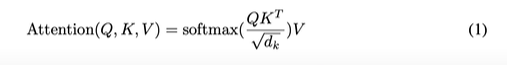

- we need to divide by the square root of head size
(scaled attention)

In [29]:
k = torch.randn(B,T,head_size)
q = torch.randn(B,T,head_size)
weights = q @ k.transpose(-2,-1) * head_size**-0.5

# scaling prevents peaking

In [ ]:
import torch
import torch.nn as nn 
from torch.nn import functional as F 
torch.manual_seed(1337)

batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.2
#file system to save model while training
MT_DRIVE = MT_DRIVE

with open('input.txt', 'r', encoding='utf-8') as f:
    text = f.read()
chars = sorted(list(set(text)))
vocab_size = len(chars)

stoi = { ch:i for i, ch in enumerate(chars)}
itos = { i:ch for i,ch in enumerate(chars)}
encode = lambda s: [stoi[c] for c in s]
decode = lambda l: ''.join([itos[i] for i in l]) 

data = torch.tensor(encode(text), dtype=torch.long)
n = int(0.9*len(data))
train_data = data[:n]
val_data = data[n:]

def get_batch(split):
    # generate small batch of data inputs x and target y
    data = train_data if split == 'train' else val_data
    # random offsets in the training data
    ix = torch.randint(len(data) - block_size, (batch_size,)) 
    
    x = torch.stack([data[i:i+block_size] for i in ix])
    y = torch.stack([data[i+1:i+block_size+1] for i in ix])
    x,y = x.to(device), y.to(device)
    return x, y

# this tells pytorch to do no back-propogation on this
# efficient in memory, not store intermediary variables here
@torch.no_grad()
def estimate_loss():
    out = {}
    # put model in eval mode to cancel dropout layers and similar
    model.eval()
    for split in ['train', 'val']:
        losses = torch.zeros(eval_iters)
        for k in range(eval_iters):
            X, Y = get_batch(split)
            logits, loss = model(X, Y)
            losses[k] = loss.item()
        out[split] = losses.mean()
    model.train()
    return out

class Head(nn.Module):
    # one head of self-attention
    def __init__(self, head_size):
        super().__init__()
        self.key = nn.Linear(n_embed, head_size, bias=False)
        self.query = nn.Linear(n_embed, head_size, bias=False)
        self.value = nn.Linear(n_embed, head_size, bias=False)
        self.register_buffer('tril', torch.tril(torch.ones(block_size, block_size)))
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        B,T,C = x.shape
        k = self.key(x)
        q = self.query(x)
        #compute attention scores
        weights = q @ k.transpose(-2,-1) * k.shape[-1]**-0.5
        weights = weights.masked_fill(self.tril[:T, :T] == 0, float('-inf'))
        weights = F.softmax(weights, dim=-1)
        weights = self.dropout(weights)
        v = self.value(x)
        out = weights @ v
        return out

class MultiHeadAttention(nn.Module):
    # multiple heads of sel-attentions in parallel
    def __init__(self, num_heads, head_size):
        super().__init__()
        self.heads = nn.ModuleList([Head(head_size) for _ in range(num_heads)])
        self.proj = nn.Linear(head_size * num_heads, n_embed)
        self.dropout = nn.Dropout(dropout)

    def forward(self, x):
        out = torch.cat([h(x) for h in self.heads], dim=-1)
        out = self.dropout(self.proj(out)) # apply linear projection
        return out

class FeedForward(nn.Module):
    # linear layer followed by ReLU (non-linearity)
    def __init__(self, n_embed):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(n_embed, 4 * n_embed), # multiply according to paper
            nn.ReLU(),
            nn.Linear(4 * n_embed, n_embed),
            nn.Dropout(dropout),
        )

    def forward(self, x):
        return self.net(x)  # per token
    
class Block(nn.Module):
    def __init__(self, n_embed, n_head):
        super().__init__()
        head_size = n_embed // n_head 
        self.sa = MultiHeadAttention(n_head, head_size)
        self.ffwd = FeedForward(n_embed)
        self.ln1 = nn.LayerNorm(n_embed)
        self.ln2 = nn.LayerNorm(n_embed)

    
    def forward(self, x):
        # deep neural connection and gradient highway
        # relieves optimization problems
        # pre-normalization - slight deviation from paper
        x = x + self.sa(self.ln1(x)) 
        x = x + self.ffwd(self.ln2(x)) 
        return x

class GPTLanguageModel(nn.Module):
    
    def __init__(self):
        super().__init__()
        self.token_embedding_table = nn.Embedding(vocab_size, n_embed)
        self.position_embedding_table = nn.Embedding(block_size, n_embed)
        self.blocks = nn.Sequential(*[Block(n_embed, n_head = n_head) for _ in range(n_layer)])
        self.ln_f = nn.LayerNorm(n_embed) # final layer normalization
        self.lm_head = nn.Linear(n_embed, vocab_size)
        self.apply(self._init_weights)
    
    def _init_weights(self, module):
        if isinstance(module, nn.Linear):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
            if module.bias is not None:
                torch.nn.init.zeros_(module.bias)
        elif isinstance(module, nn.Embedding):
            torch.nn.init.normal_(module.weight, mean=0.0, std=0.02)
        
    def forward(self, idx, targets=None):
        B, T = idx.shape
        # every int in input correspond to row in embed table
        # (Batch, Time, Channel) - logits - score of next character 
        tok_emb = self.token_embedding_table(idx)
        pos_emb = self.position_embedding_table(torch.arange(T, device=device)) #(T,C)
        x = tok_emb + pos_emb # (B,T,C)
        x =  self.blocks(x)
        x = self.ln_f(x)
        logits = self.lm_head(x) #(B, T, vocab_size ) decoder
        #x holds not only token identity but also when it occurs
        
        if targets is None:
            loss = None
        else:
            #rearrange torch to fit loss function
            B, T, C = logits.shape
            logits = logits.view(B*T, C)
            targets = targets.view(B*T)
            # loss function - negative log likelihood = cross entropy
            loss = F.cross_entropy(logits, targets)

        return logits, loss

    def generate(self, idx, max_new_tokens):
        #idx is (B, T) array of indices in the current context
        # generate should take (B, T) to (B, T+1)
        for _ in range(max_new_tokens):
            # crop idx to the last block_size tokens
            idx_cond = idx[:, -block_size:]

            # get prediction
            logits, loss = self(idx_cond)
            # filter to only last time step (bigram)
            logits = logits[:, -1, :] # format is (B, C)
            # apply softmax to get probabilities
            probs = F.softmax(logits, dim=1) # format is (B, C)
            # generate next sample from distribution
            idx_next = torch.multinomial(probs, num_samples=1) # shape is (B, 1)
            # concatenate to input stream
            idx = torch.cat((idx, idx_next), dim=1) # shape is (B, T+1)
        return idx

model = GPTLanguageModel()
model = model.to(device)

optimizer = torch.optim.AdamW(model.parameters(), lr=learning_rate)

for iter in range(max_iters):

    if iter % eval_interval == 0 or iter == max_iters - 1:
        losses = estimate_loss()
        print(f"step {iter}: train loss {losses['train']}, val loss {losses['val']:.4f}")
        #save the model to google drive
        if(MT_DRIVE != None):
          PATH = MT_DRIVE+'model_%04d.h5' % (iter)
          torch.save(model.state_dict(), PATH)
    
    xb, yb = get_batch('train')
    #evaluate loss
    logits, loss = model(xb, yb)
    optimizer.zero_grad(set_to_none=True)
    loss.backward()
    optimizer.step()
    



```
config:
batch_size = 64
block_size = 256
max_iters = 5000
eval_interval = 500
learning_rate = 1e-3
device = 'cuda' if torch.cuda.is_available() else 'cpu'
eval_iters = 200
n_embed = 384
n_head = 6
n_layer = 6
dropout = 0.2

training:
step 0: train loss 4.2220964431762695, val loss 4.2306
step 500: train loss 1.827948808670044, val loss 1.9795
step 1000: train loss 1.4373588562011719, val loss 1.6409
step 1500: train loss 1.2761036157608032, val loss 1.5364
step 2000: train loss 1.182935357093811, val loss 1.4961
step 2500: train loss 1.1115370988845825, val loss 1.4910
step 3000: train loss 1.056115984916687, val loss 1.4863
step 3500: train loss 0.9962823390960693, val loss 1.5177
step 4000: train loss 0.9282923936843872, val loss 1.5294
step 4500: train loss 0.8748894333839417, val loss 1.5694
step 4999: train loss 0.815987765789032, val loss 1.5962
```
show signs of overfitting after iteration 3000, next run should lower the learning rate to 3e-4

In [ ]:
# generate from the model
import torch
context = torch.zeros((1, 1), dtype=torch.long, device=device)
print(decode(model.generate(context, max_new_tokens=500)[0].tolist()))
#open('more.txt', 'w').write(decode(m.generate(context, max_new_tokens=10000)[0].tolist()))

output:
```
But what present I with steel wind to come?
For my Coriolanus commend;  farewell let:
That wisely good figure and rival madie:
The fair body that unsheathed be five.
But yet how may living so green is come;
And then revel with sorrow dead-blind pack'd my sen
So faio, is happy life to win children!

COMINIUS:
Mole conduct, his is care off! and spiea,
My work is much streak, that not sicks, which 'im
Can dispersed their mate?

JUCITIO:
Is it no less, I dae.

MERCUTIO:
Why, how near you, a thing ne
```

apply multi-head attention
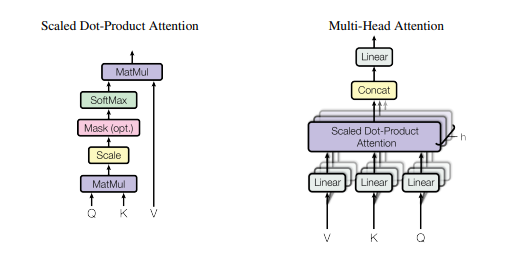

multiple attentions in parallel, concatenated

require linear scaling

add dropout layers for efficient training - "like having an ensemble of training models at the same time"

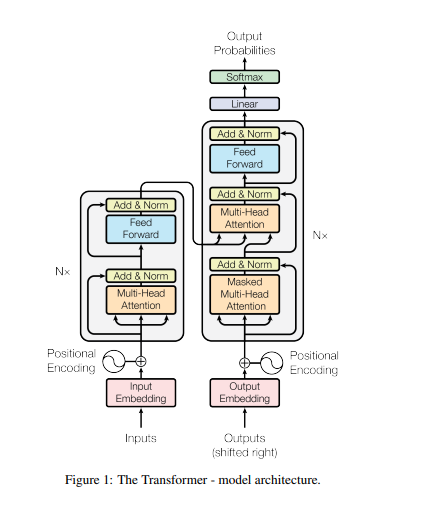

We have a decoder in place. So given an input context - the model can compute the likely completion

Missing the encoder. 
Encoder provide keys-values into the decoder "cross-attention"

GPT is also a decoder-only system. 

nanoGPT

same structure but more complicated with checkpoint logic, loaded pretrained weights, distributing training accross gpus, etc

CasualSelfAttention implements each head in a batched way to provide the heads as a fourth dimension - more efficient


chatGPT

training has 2 stages. 
- pretrain: large chunk of internet, decoder only. babble text. Our shakespear transformer has about 10,000,000 parameters with input token size of 300,000 tokens
- chatGPT paper train on subword chunk -> dataset 300Billion tokens. chatGPT has 175B parameters
    n_layers = 96
    n_embed = 12288
    n_heads = 96
    head_size = 128
    batch-size = 3,2M
- 1000s of gpu infrastructure
- output is a document completer 'babbler'

- finetune stage: align into an assistant
- 1. Collect training data of assistant question-answer style. Feed it to model -> align to that style.
- 2. Collect comparison data and train reward model. 
- 3. Use PPO reinforcement algorithm to train model to output answer that score high with the reward model. 
